# Avance 5

En este notebook se exploran métricas para medir el rendimiento del RAG propuesto. El RAG utiliza el modelo GTE-Large-en-v1.5 de Alibaba para la construcción de la base de datos vectorial a partir de texto y el embedding de las preguntas para la etapa de retrieve del RAG. Finalmente, se emplea GPT-3.5-turbo para la generación de respuestas.

Para medir el rendimiento del RAG, se utilizará una muestra de 536 preguntas del dataset "Natural Questions" de Google. Este dataset contiene preguntas realizadas en lenguaje natural, el contenido de una página de Wikipedia relacionada con la pregunta y una sección de texto de la página donde se encuentra la respuesta.

### Similitud de coseno

Durante el proceso de creación del dataset de validación, se utilizó la arquitectura de RAG propuesta para generar las respuestas a las preguntas del dataset "Natural Questions". Además, se generaron respuestas a las preguntas tomando como contexto las anotaciones en las cuales se encontraba el fragmento de texto que contenía la respuesta.

El siguiente paso implicará la creación de embeddings tanto de las respuestas generadas con el RAG, como de las respuestas generadas con el contexto del fragmento de texto que contiene la respuesta, y del propio fragmento de texto con la respuesta a la pregunta. Posteriormente, se calculará la similitud de coseno entre las respuestas generadas por el RAG y las respuestas generadas con el contexto del fragmento de texto con la respuesta a la pregunta, así como entre las respuestas del RAG y el fragmento de texto con la respuesta a la pregunta.

In [1]:
import json

file_path = 'validation_data_with_context.jsonl'

# Leer el archivo línea por línea
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]

# Mostrar algunos datos para verificar
print(data[:1])

[{'id': 0, 'question_text': 'who wrote the song photograph by ringo starr', 'question_answer': "<P> `` Photograph '' is a song by English musician Ringo Starr that was released as the lead single from his 1973 album Ringo . Starr co-wrote the song with George Harrison , his former bandmate from the Beatles . Although the two of them collaborated on other compositions , it is the only song officially credited to the pair . A signature tune for Starr as a solo artist , `` Photograph '' became an international hit , topping singles charts in the United States , Canada and Australia , and receiving gold disc certification for US sales of 1 million . Music critics have similarly received the song favourably ; Stephen Thomas Erlewine of AllMusic considers it to be `` among the very best post-Beatles songs by any of the Fab Four '' . </P>", 'document_text': 'Photograph ( Ringo Starr song ) - wikipedia <H1> Photograph ( Ringo Starr song ) </H1> Jump to : navigation , search <Table> <Tr> <Th_co

In [3]:
data[0].keys()

dict_keys(['id', 'question_text', 'question_answer', 'document_text', 'rag_answer', 'ground_truth_answer', 'context'])

In [48]:
from dotenv import load_dotenv,find_dotenv

# Load OpenAI API key from .env file
load_dotenv(find_dotenv())

True

In [8]:
from openai import OpenAI
import re

client = OpenAI()

def get_embedding(text, model="text-embedding-3-large"):
    # Eliminar todos los tags de HTML
    text = re.sub(r'<.*?>', '', text)
    # Reemplazar los saltos de línea por espacios
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding


for entry in data:

    entry['rag_answer_embedding'] = get_embedding(entry['rag_answer'])
    entry['ground_truth_answer_embedding'] = get_embedding(entry['ground_truth_answer'])
    entry['question_answer_embedding'] = get_embedding(entry['question_answer'])


In [5]:
data[0].keys()

dict_keys(['id', 'question_text', 'question_answer', 'document_text', 'rag_answer', 'ground_truth_answer', 'context', 'rag_answer_embedding', 'ground_truth_answer_embedding', 'question_answer_embedding'])

In [9]:
# Guardar los datos procesados en un nuevo archivo JSONL excluyendo 'document_text'
with open('validation_data_embeddings.jsonl', 'w') as outfile:
    for entry in data:
        json.dump(entry, outfile)
        outfile.write('\n')

In [10]:
import numpy as np

def cosine_similarity(vec1, vec2):

    # Convertir a numpy arrays si no lo son
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    
    # Calcular el producto punto y las magnitudes de los vectores
    dot_product = np.dot(vec1, vec2)
    magnitude_vec1 = np.linalg.norm(vec1)
    magnitude_vec2 = np.linalg.norm(vec2)
    
    # Calcular la similitud de coseno
    if magnitude_vec1 == 0 or magnitude_vec2 == 0:
        return 0.0
    return dot_product / (magnitude_vec1 * magnitude_vec2)


In [69]:
a = client.embeddings.create(input=['I like white snow'], model="text-embedding-3-large").data[0].embedding
b = client.embeddings.create(input=['I love white snow'], model="text-embedding-3-large").data[0].embedding

cosine_similarity(a,b)

0.9335189537737955

In [70]:
a = client.embeddings.create(input=['I like white snow'], model="text-embedding-3-large").data[0].embedding
b = client.embeddings.create(input=['I like warm sand'], model="text-embedding-3-large").data[0].embedding

cosine_similarity(a,b)

0.4570660419518667

In [11]:
for entry in data:

    entry['sim_rag_ground_truth'] = cosine_similarity(entry['rag_answer_embedding'],entry['ground_truth_answer_embedding'])
    entry['sim_rag_question_answer'] = cosine_similarity(entry['rag_answer_embedding'],entry['question_answer_embedding'])

In [12]:
list_sim_rag_ground_truth = [entry['sim_rag_ground_truth'] for entry in data]
list_sim_rag_question_answer = [entry['sim_rag_question_answer'] for entry in data]

In [20]:
# Guardar los datos procesados en un nuevo archivo JSONL excluyendo 'document_text'
with open('validation_data_sim.jsonl', 'w') as outfile:
    for entry in data:
        json.dump(entry, outfile)
        outfile.write('\n')

/var/folders/tl/8p6q8vp1621_qbt9h5tg1tlh0000gn/T/ipykernel_18916/170714161.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot([list_sim_rag_ground_truth, list_sim_rag_question_answer], labels=['RAG vs Ground Truth', 'RAG vs Question Answer'])


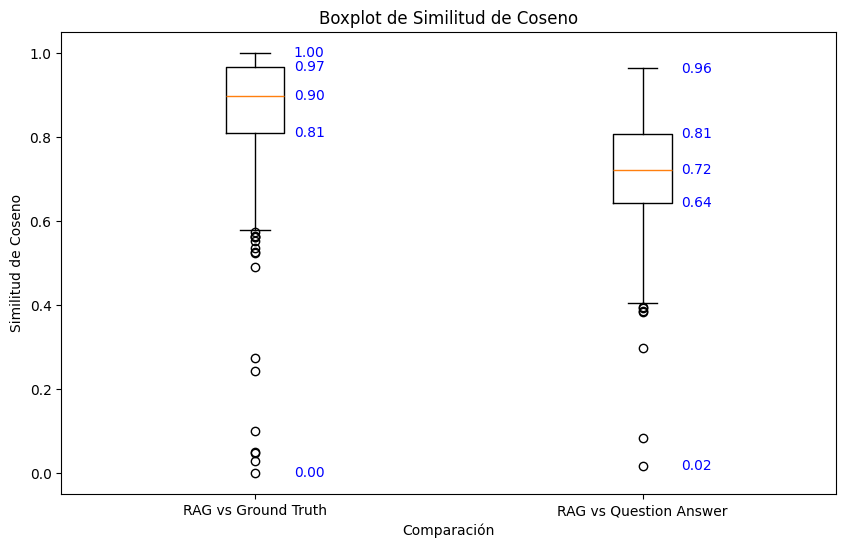

In [23]:
import matplotlib.pyplot as plt

# Crear el boxplot
fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot([list_sim_rag_ground_truth, list_sim_rag_question_answer], labels=['RAG vs Ground Truth', 'RAG vs Question Answer'])

# Añadir títulos y etiquetas
plt.title('Boxplot de Similitud de Coseno')
plt.xlabel('Comparación')
plt.ylabel('Similitud de Coseno')

# Función para agregar etiquetas de cuantiles
def add_quantile_labels(box_data, boxplot, ax):
    for i in range(len(box_data)):
        q1 = np.percentile(box_data[i], 25)
        q2 = np.percentile(box_data[i], 50)
        q3 = np.percentile(box_data[i], 75)
        whisker_low = np.min(box_data[i])
        whisker_high = np.max(box_data[i])

        ax.text(i + 1.1, q1, f'{q1:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, q2, f'{q2:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, q3, f'{q3:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, whisker_low, f'{whisker_low:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, whisker_high, f'{whisker_high:.2f}', verticalalignment='center', fontsize=10, color='blue')

# Añadir etiquetas de cuantiles a los boxplots
add_quantile_labels([list_sim_rag_ground_truth, list_sim_rag_question_answer], box, ax)

# Mostrar el gráfico
plt.show()

In [24]:
print('Similitud promedio - Respuesta RAG, Ground Truth generado:', np.mean(list_sim_rag_ground_truth))
print('Similitud promedio - Respuesta RAG, Anotación de texto que contiene la respuesta:', np.mean(list_sim_rag_question_answer))

Similitud promedio - Respuesta RAG, Ground Truth generado: 0.8653401034490289
Similitud promedio - Respuesta RAG, Anotación de texto que contiene la respuesta: 0.7159738274065733


Se puede observar que se obtiene un valor alto de similitud (**0.86** en promedio) entre las respuestas generadas por la arquitectura RAG y las respuestas generadas a partir de las anotaciones con los fragmentos de texto que contienen las respuestas a las preguntas. Además, se obtiene una similitud considerablemente alta (**0.72** en promedio) entre las respuestas generadas por el RAG y las anotaciones de los fragmentos de texto que contienen la respuesta. En este caso, la similitud es un poco menor que en el primer caso, ya que normalmente las anotaciones son párrafos que contienen información adicional a la respuesta.

### Calificación con LLM (gpt-40)

In [78]:
def evaluate_similarity(answer_set_1, answer_set_2):
    system_prompt = (
        "You are a grader responsible for evaluating the similarity between two sets of question answers. Your task is to provide a score between 0 and 10, where 0 indicates no similarity between the answers and 10 indicates a high degree of similarity. Ensure your evaluation is thorough, considering the content, context, and details of each answer to accurately determine their similarity. Return only the grade between 0 and 10"
    )

    user_prompt = f"Please evaluate the similarity between the following two sets of question answers, the sesponse should be only the grade:\n\n" \
                  f"Question Answer Set 1:\n" \
                  f"1. {answer_set_1}\n\n" \
                  f"Question Answer Set 2:\n" \
                  f"1. {answer_set_2}"

    response = client.chat.completions.create(
        model="gpt-4o",
        #model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        max_tokens=10,
        temperature=0
    )

    return response.choices[0].message.content

# Example usage:
answer_set_1 = "The capital of France is Paris."
answer_set_2 = "Paris is the capital of France."
similarity_score = evaluate_similarity(answer_set_1, answer_set_2)
print(similarity_score)


10


In [79]:
# Example usage:
answer_set_1 = "The capital of France is Paris."
answer_set_2 = "Bogota is the capital of Colombia."
similarity_score = evaluate_similarity(answer_set_1, answer_set_2)
print(similarity_score)

0


In [80]:
for entry in data:

    entry['LLM_grade'] = evaluate_similarity(entry['rag_answer'],entry['ground_truth_answer'])

8.0 9.0 10.0


/var/folders/tl/8p6q8vp1621_qbt9h5tg1tlh0000gn/T/ipykernel_18916/3960593918.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot([list_llm_grade], labels=['RAG vs Ground Truth'])


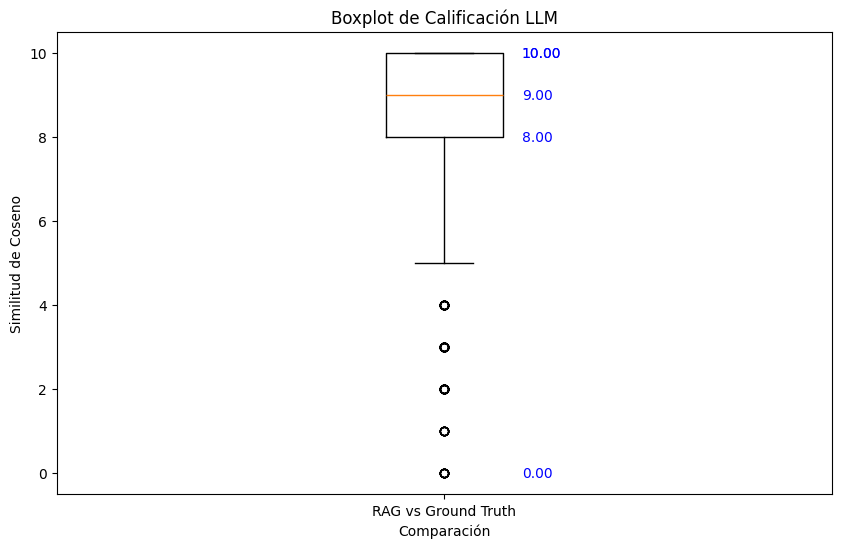

In [90]:
list_llm_grade = [int(entry['LLM_grade']) for entry in data]

# Crear el boxplot
fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot([list_llm_grade], labels=['RAG vs Ground Truth'])

# Añadir títulos y etiquetas
plt.title('Boxplot de Calificación LLM')
plt.xlabel('Comparación')
plt.ylabel('Similitud de Coseno')

# Función para agregar etiquetas de cuantiles
def add_quantile_labels(box_data, boxplot, ax):
    for i in range(len(box_data)):
        q1 = np.percentile(box_data[i], 25)
        q2 = np.percentile(box_data[i], 50)
        q3 = np.percentile(box_data[i], 75)
        whisker_low = np.min(box_data[i])
        whisker_high = np.max(box_data[i])
        print(q1, q2, q3)

        ax.text(i + 1.1, q1, f'{q1:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, q2, f'{q2:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, q3, f'{q3:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, whisker_low, f'{whisker_low:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, whisker_high, f'{whisker_high:.2f}', verticalalignment='center', fontsize=10, color='blue')

# Añadir etiquetas de cuantiles a los boxplots
add_quantile_labels([list_llm_grade], box, ax)

# Mostrar el gráfico
plt.show()

In [89]:
# Guardar los datos procesados en un nuevo archivo JSONL excluyendo 'document_text'
with open('validation_data_llm_grade.jsonl', 'w') as outfile:
    for entry in data:
        json.dump(entry, outfile)
        outfile.write('\n')

In [91]:
print('Calificación promedio - Respuesta RAG, Ground Truth generado:', np.mean(list_llm_grade))

Calificación promedio - Respuesta RAG, Ground Truth generado: 7.934701492537314


En la métrica propuesta, también se obtuvo un resultado notable. El modelo de lenguaje de gran escala (LLM) proporcionó un promedio de calificación de **7.9**. Además, un análisis más detallado revela que el **75%** de las calificaciones otorgadas están por encima de **8**, lo que indica un alto nivel de desempeño y consistencia en la calidad de las respuestas generadas por el modelo.

### Evaluar con LLM si se genera una respuesta relevante para la pregunta

In [93]:
def evaluate_relevance(question, answer):
    system_prompt = (
        "You are a grader responsible for evaluating the relevance and accuracy of a pair of question and answer. Your task is to provide a score between 0 and 10, where 0 indicates no relevance and accuracy between the question and answer, and 10 indicates a high degree of relevance and accuracy. Ensure your evaluation is thorough, considering the content, context, and details. Return only the grade between 0 and 10."
    )

    user_prompt = f"Please evaluate the relevance and accuracy of the following answer given the question. The response should be only the grade:\n\n" \
                  f"Question:\n" \
                  f"{question}\n\n" \
                  f"Answer:\n" \
                  f"{answer}"

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        max_tokens=10,
        temperature=0
    )

    return response.choices[0].message.content

# Example usage:
question = "What is the capital of France?"
answer = "The capital of France is Paris."
relevance_score = evaluate_relevance(question, answer)
print(relevance_score)


10


In [94]:
# Example usage:
question = "What is the capital of France?"
answer = "The capital of France is Bogotá."
relevance_score = evaluate_relevance(question, answer)
print(relevance_score)

0


In [95]:
for entry in data:

    entry['LLM_grade_relevance_accuracy'] = evaluate_relevance(entry['question_text'],entry['rag_answer'])

9.0 10.0 10.0


/var/folders/tl/8p6q8vp1621_qbt9h5tg1tlh0000gn/T/ipykernel_18916/2582422467.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot([list_llm_grade_relevance_accuracy], labels=['Relevancia de respuesta'])


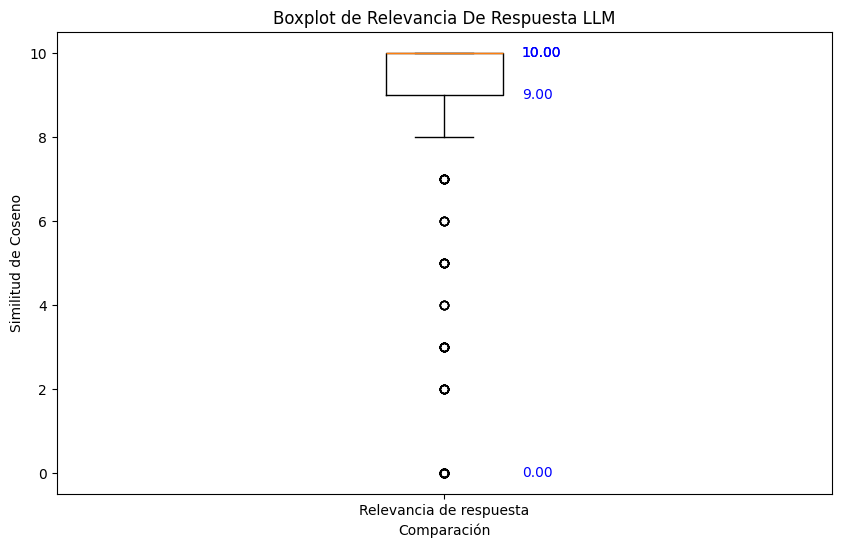

In [96]:
list_llm_grade_relevance_accuracy = [int(entry['LLM_grade_relevance_accuracy']) for entry in data]

# Crear el boxplot
fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot([list_llm_grade_relevance_accuracy], labels=['Relevancia de respuesta'])

# Añadir títulos y etiquetas
plt.title('Boxplot de Relevancia De Respuesta LLM')
plt.xlabel('Comparación')
plt.ylabel('Similitud de Coseno')

# Función para agregar etiquetas de cuantiles
def add_quantile_labels(box_data, boxplot, ax):
    for i in range(len(box_data)):
        q1 = np.percentile(box_data[i], 25)
        q2 = np.percentile(box_data[i], 50)
        q3 = np.percentile(box_data[i], 75)
        whisker_low = np.min(box_data[i])
        whisker_high = np.max(box_data[i])
        print(q1, q2, q3)

        ax.text(i + 1.1, q1, f'{q1:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, q2, f'{q2:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, q3, f'{q3:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, whisker_low, f'{whisker_low:.2f}', verticalalignment='center', fontsize=10, color='blue')
        ax.text(i + 1.1, whisker_high, f'{whisker_high:.2f}', verticalalignment='center', fontsize=10, color='blue')

# Añadir etiquetas de cuantiles a los boxplots
add_quantile_labels([list_llm_grade_relevance_accuracy], box, ax)

# Mostrar el gráfico
plt.show()

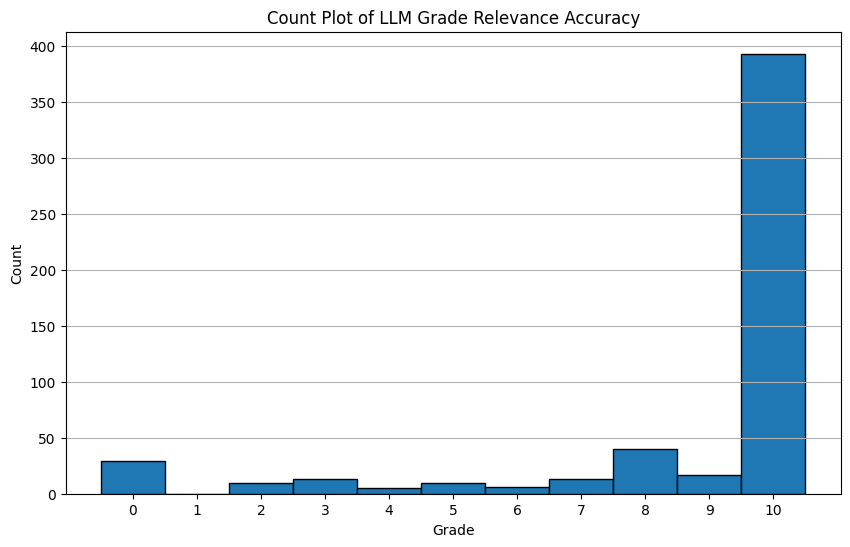

In [97]:
plt.figure(figsize=(10, 6))
plt.hist(list_llm_grade_relevance_accuracy, bins=range(0, 12), edgecolor='black', align='left')
plt.xticks(range(0, 11))
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Count Plot of LLM Grade Relevance Accuracy')
plt.grid(axis='y')

# Display the plot
plt.show()

Con este método de evaluación, podemos evidenciar que la arquitectura RAG propuesta está logrando generar respuestas altamente relevantes a las preguntas formuladas. Un análisis detallado revela que el **75%** de las preguntas recibieron una calificación de **9** o **10**. Este resultado subraya la eficacia y precisión del modelo en proporcionar respuestas de alta calidad, lo que refuerza su potencial en aplicaciones prácticas.

### RAGAs

In [31]:
data[1].keys()

dict_keys(['id', 'question_text', 'question_answer', 'document_text', 'rag_answer', 'ground_truth_answer', 'context', 'rag_answer_embedding', 'ground_truth_answer_embedding', 'question_answer_embedding', 'sim_rag_ground_truth', 'sim_rag_question_answer'])

In [36]:
import json

file_path = 'validation_data_sim.jsonl'

# Leer el archivo línea por línea
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]

# Mostrar algunos datos para verificar
print(data[:1])

[{'id': 0, 'question_text': 'who wrote the song photograph by ringo starr', 'question_answer': "<P> `` Photograph '' is a song by English musician Ringo Starr that was released as the lead single from his 1973 album Ringo . Starr co-wrote the song with George Harrison , his former bandmate from the Beatles . Although the two of them collaborated on other compositions , it is the only song officially credited to the pair . A signature tune for Starr as a solo artist , `` Photograph '' became an international hit , topping singles charts in the United States , Canada and Australia , and receiving gold disc certification for US sales of 1 million . Music critics have similarly received the song favourably ; Stephen Thomas Erlewine of AllMusic considers it to be `` among the very best post-Beatles songs by any of the Fab Four '' . </P>", 'document_text': 'Photograph ( Ringo Starr song ) - wikipedia <H1> Photograph ( Ringo Starr song ) </H1> Jump to : navigation , search <Table> <Tr> <Th_co

In [44]:
from datasets import Dataset

# To dict
data_eval = {
    "question": [entry['question_text'] for entry in data],
    "answer": [entry['rag_answer'] for entry in data],
    "contexts": [[entry['context']] for entry in data],
    "ground_truth": [entry['ground_truth_answer'] for entry in data]
}

# Convert dict to dataset
dataset = Dataset.from_dict(data_eval)

In [45]:
dataset['contexts'][0]

['to the pair . A signature tune for Starr as a solo artist , `` Photograph \'\' became an international hit , topping singles charts in the United States , Canada and Australia , and receiving gold disc certification for US sales of 1 million . Music critics have similarly received the song favourably ; Stephen Thomas Erlewine of AllMusic considers it to be `` among the very best post-Beatles songs by any of the Fab Four \'\' . </P> <P> The lyrics are a reflection on lost love , whereby a photograph is the only reminder of the protagonists \' shared past . Starr and Harrison began writing the song in the South of France in 1971 , during a period when Starr was focused on developing his acting career . They first recorded `` Photograph \'\' late the following year , along with the single \'s B - side , `` Down and Out \'\' , during sessions for Harrison \'s Living in the Material World album ( 1973 ) . The officially released version was recorded in Los Angeles with producer Richard Pe

In [51]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    #answer_similarity,
    #answer_correctness,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        #answer_similarity,
        #answer_correctness
    ],
)

df = result.to_pandas()

Evaluating:   0%|          | 0/2144 [00:00<?, ?it/s]

Exception in thread Thread-72:
Traceback (most recent call last):
  File "/Users/johan/opt/anaconda3/envs/proyint/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/johan/opt/anaconda3/envs/proyint/lib/python3.10/site-packages/ragas/executor.py", line 95, in run
    results = self.loop.run_until_complete(self._aresults())
  File "/Users/johan/opt/anaconda3/envs/proyint/lib/python3.10/asyncio/base_events.py", line 649, in run_until_complete
    return future.result()
  File "/Users/johan/opt/anaconda3/envs/proyint/lib/python3.10/site-packages/ragas/executor.py", line 83, in _aresults
    raise e
  File "/Users/johan/opt/anaconda3/envs/proyint/lib/python3.10/site-packages/ragas/executor.py", line 78, in _aresults
    r = await future
  File "/Users/johan/opt/anaconda3/envs/proyint/lib/python3.10/asyncio/tasks.py", line 571, in _wait_for_one
    return f.result()  # May raise f.exception().
  File "/Users/johan/opt/anaconda3/envs/proyint/lib/python3

ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exceptions=False` incase you want to show only a warning message instead.

No fue posible utilizar RAGAs para realizar la evaluación del RAG ya que se sobrepasa los limites del API de OpenAI